In [30]:
from collections import defaultdict
import os
import pathlib
import pickle

from astropy.stats import median_absolute_deviation as MAD
from astropy.utils.misc import isiterable
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import binned_statistic, binned_statistic_2d
from tqdm.notebook import tqdm
from scipy.spatial import cKDTree

from gala.mpl_style import turbo

import arviz as az
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
from scipy.stats import cauchy, norm
from scipy.special import logsumexp
import exoplanet as xo

In [304]:
allstar_file = pathlib.Path(
    '/mnt/home/apricewhelan/data/APOGEE_DR17/allStar-dr17-l33alpha.fits')
allvisit_file = pathlib.Path(
    '/mnt/home/apricewhelan/data/APOGEE_DR17/allVisit-dr17-l33alpha.fits')

In [305]:
def get_bin_mask(allstar, **kwargs):
    bin_mask = np.ones(len(allstar), dtype=bool)
    
    for k, lim in kwargs.items():
        bin_mask &= (allstar[k] > lim[0]) & (allstar[k] < lim[1]) 
        
    return bin_mask


def equal_N_bins(x, N_per_bin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, N_per_bin + 1),
                     np.arange(npt),
                     np.sort(x))

In [360]:
def get_visits(allstar, allvisit, **kwargs):
    bin_mask = get_bin_mask(
        allstar, **kwargs) 
    
    stars = allstar[bin_mask]
    visits = allvisit[np.isin(allvisit['APOGEE_ID'], stars['APOGEE_ID'])]
    
    if len(stars) < 1 or len(visits) < 1:
        return None, None
    
    visits = at.join(visits, stars['APOGEE_ID', 'VHELIO_AVG', 'TEFF', 'LOGG', 'M_H', 'VSINI'], 
                     keys='APOGEE_ID', join_type='left')
    visits = at.unique(visits, keys=('PLATE', 'MJD', 'FIBERID'))
    # visits['DVHELIO'] = visits['VHELIO'] - visits['VHELIO_AVG']
    
    df = visits['APOGEE_ID', 'VHELIO'].to_pandas()
    df['VHELIO_MEAN'] = df.groupby('APOGEE_ID')['VHELIO'].transform('mean')
    visits['DVHELIO'] = (df['VHELIO'] - df['VHELIO_MEAN']).values
    
    return stars, visits


def visits_to_data(visits):
    data = {
        'vs': np.array(visits['DVHELIO']),
        # 'teffs' : np.array(visits['TEFF']),
        'snrs': np.array(visits['SNR']),
        'm_hs': np.array(visits['M_H']),
        # 'loggs': np.array(visits['LOGG']),
        'vsinis': np.array(visits['VSINI'])
    }
    return data


def get_MAP_estimate(visits, model, init_pars=None, **kwargs):
    if init_pars is None:
        init_pars = {
                'a_0': 0.05,
                'a_z1': -0.003,
                'b_0': 0.05,
                'b_z1': 1e-4,
                'b_vrot1': 0.01465298,
                'f_vrot': 0.09,
                'lnbs1': 1.6,
                'lnbs2': 4.5,
                'w': np.ones(K)
            }
        
    _pars = init_pars.copy()

    data = visits_to_data(visits)
    
    kwargs.setdefault('progress', False)
    kwargs.setdefault('verbose', False)
    kwargs.setdefault('method', 'L-BFGS-B')
    
    for i in range(8):  # MAX ITER
        init_pars = {k: np.array(v) 
                     for k, v in _pars.items()}.copy()

        with model:
            pm.set_data(data)
            try:
                map_estimate = pmx.optimize(
                    start=init_pars, 
                    **kwargs)
                if np.all([np.all(np.isfinite(v)) for v in map_estimate.values()]):
                    break
            except Exception as e:
                print(f"FAILURE: iteration {i}")
                print(e)
                print(init_pars)
                return None
    
    return map_estimate

In [307]:
# DR17 alpha
allstar = at.Table.read(allstar_file, hdu=1)
allstar = at.unique(allstar, keys='APOGEE_ID')

allvisit = at.Table.read(allvisit_file, hdu=1)

In [333]:
# BITMASK shiz
allstar = allstar[((allstar['ASPCAPFLAG'] & (2**23)) == 0) &  # STAR_BAD
                  ((allstar['STARFLAG'] & (2**21)) == 0) &  # MULTIPLE_SUSPECT
                  (allstar['M_H'] > -2.5)]

starflag_bits = np.array([0, 3, 9, 16, 19, 20])
starflag_mask = (allvisit['STARFLAG'] % np.sum(2**starflag_bits)) == 0

# RV_FLAG and SB2
visit_rv_mask = ((allvisit['N_COMPONENTS'] == 1) & 
                 (allvisit['RV_FLAG'] == 0) &
                 (allvisit['SNR'] > 4) &
                 (np.isfinite(allvisit['VHELIO'])) &
                 (np.isin(allvisit['APOGEE_ID'], allstar['APOGEE_ID'])))

allvisit = allvisit[starflag_mask & visit_rv_mask]

In [334]:
allvisit = at.unique(allvisit, keys=('PLATE', 'MJD', 'FIBERID'))
apids, counts = np.unique(allvisit['APOGEE_ID'], return_counts=True)

allstar = allstar[np.isin(allstar['APOGEE_ID'], 
                          apids[counts >= min_nvisits])]
allvisit = allvisit[np.isin(allvisit['APOGEE_ID'], 
                            apids[counts >= min_nvisits])]

len(allstar), len(allvisit)

(236527, 1102942)

In [361]:
stars, visits = get_visits(
    allstar, allvisit,
    TEFF=(2000, 8000),
    LOGG=(-0.6, 6),
    M_H=(-3, 1))

In [362]:
_, counts = np.unique(allvisit['APOGEE_ID'], return_counts=True)
assert counts.min() >= min_nvisits

_, counts = np.unique(visits['APOGEE_ID'], return_counts=True)
assert counts.min() >= min_nvisits

assert np.all(visits['DVHELIO'] != 0)

In [363]:
# vsini_bins = [0, 4, 16, 32, 100]
# for l, r in zip(vsini_bins[:-1], vsini_bins[1:]):
#     vsini_mask = get_bin_mask(allstar, VSINI=(l, r))
#     fig, ax = plt.subplots(1, 1, figsize=(6, 6))

#     ax.hist2d(allstar['TEFF'][vsini_mask], allstar['LOGG'][vsini_mask], 
#               bins=(np.linspace(teff_ctrs.min(), teff_ctrs.max(), 128),
#                     np.linspace(logg_ctrs.min(), logg_ctrs.max(), 128)),
#               norm=mpl.colors.LogNorm(),
#               cmap='Blues');

#     ax.set_xlabel('TEFF')

#     ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
#     ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
#     ax.set_ylabel('LOGG')

#     fig.tight_layout()
#     fig.set_facecolor('w')

## Model:

$$
\begin{align}
Z &= 10^{[{\rm M}/{\rm H}]}\\
v^* &= \sqrt{(v\sin i)^2 + (c/R)^2}\\
\Delta Z &= (Z - Z_0)\\
a &= a_{0} + a_{Z, 1} \, \Delta Z\\
b &= b_{0} + b_{Z, 1} \, \Delta Z\\
\sigma_v^2 &= a^2 + b^2 \, \left( \frac{\rm SNR}{{\rm SNR}_0} \right)^{-2} + b_{v\sin i}^2 \, ((v\sin i)^2 + (c/R)^2)\\
\tilde{v} &\sim w_1 \, \mathcal{N}(0, \sigma_v^2) + 
    w_2 \, \mathcal{N}(0, \sigma_v^2 + \sigma_{\rm bin, 1}^2) + 
    w_3 \, \mathcal{N}(0, \sigma_v^2 + \sigma_{\rm bin, 1}^2 + \sigma_{\rm bin, 2}^2)
\end{align}
$$

In [364]:
from astropy.constants import c as speedoflight
R = 22500
vsini_floor = (speedoflight / R).to_value(u.km/u.s)

In [365]:
# _grid = np.linspace(1, 100, 128)
# # plt.plot(_grid, np.sqrt(6e-3**2 * (_grid**2 + vsini_floor**2)))
# plt.plot(_grid, np.sqrt(6e-3**2 * (_grid/vsini_floor)**2 + 0.05**2))

In [423]:
with pm.Model() as model:
    snr0 = pm.Data('snr0', 40.)
    Z0 = pm.Data('Z0', 1.)
    
    vs = pm.Data('vs', np.zeros(1))
    snrs = pm.Data('snrs', np.zeros(1))
    m_hs = pm.Data('m_hs', np.zeros(1))
    vsinis = pm.Data('vsinis', np.zeros(1))
    
    # cluster sizes
    K = 3
    ws = pm.Dirichlet("w", a=np.ones(K), shape=K)

    Z = 10 ** m_hs
    dZ = Z - Z0
    b_vrot1 = pm.Bound(pm.Normal, lower=0.)('b_vrot1', 0, 0.1)
    f_vrot = pm.Bound(pm.Normal, lower=0)('f_vrot', 0, 0.1)
    vsini_term = b_vrot1**2 * (vsinis**2 + f_vrot * vsini_floor**2)

    a_0 = pm.Normal('a_0', 0, 0.1)
    a_z1 = pm.Normal('a_z1', 0, 0.2)
    a = a_0 + a_z1 * dZ
    
    b_0 = pm.Normal('b_0', 0, 0.2)
    b_z1 = pm.Normal('b_z1', 0, 0.2)
    b = b_0 + b_z1 * dZ
    
    err1 = pm.Deterministic('err1', np.sqrt(a**2 + b**2 / (snrs / snr0)**2 + vsini_term))
    
    norm1 = pm.Normal.dist(0, err1)
    
    # binaries
    lnbs1 = pm.Uniform('lnbs1', -0.7, 4)
    binary_std1 = tt.exp(lnbs1)
    err2 = pm.Deterministic('err2', np.sqrt(err1**2 + binary_std1**2))
    norm2 = pm.Normal.dist(0, err2)
    
    # excess variance
    lnbs2 = pm.Uniform('lnbs2', 1.6, 5.5)
    binary_std2 = tt.exp(lnbs2)
    err3 = pm.Deterministic('err3', np.sqrt(err2**2 + binary_std2**2))
    norm3 = pm.Normal.dist(0, err3)

    # likelihood for each observed value
    like = pm.Mixture('like', 
                      w=ws, 
                      comp_dists=[norm1, norm2, norm3],
                      observed=vs)
    
    pm.Deterministic('logp1', norm1.logp(vs))
    pm.Deterministic('logp2', norm2.logp(vs))
    pm.Deterministic('logp3', norm3.logp(vs))

### Metric and grid setup

Overlapping bins, for a given star, take the box center closest to the star's position in logg, teff

In [424]:
teff_step = 400
logg_step = 0.4
# teff_step = 600
# logg_step = 0.6

teff_half_size = teff_step * 3 / 2
logg_half_size = logg_step * 3 / 2

teff_ctrs = np.arange(3000, 8000+1e-3, teff_step)
logg_ctrs = np.arange(-logg_step, 6+1e-3, logg_step)
# teff_ctrs = np.arange(3000, 8000+1e-3, teff_step)
# logg_ctrs = np.array([4.5])

teff_grid, logg_grid = np.meshgrid(teff_ctrs, logg_ctrs)

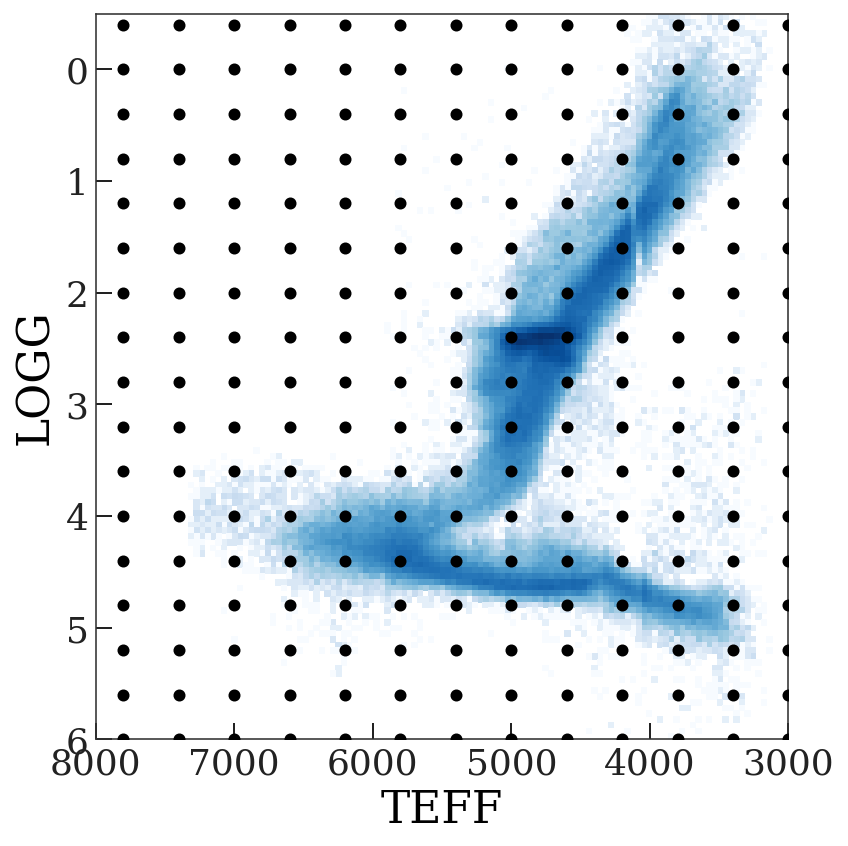

In [425]:
plot_teff_logg_bins = (np.linspace(3000, 8000, 128),
                       np.linspace(-0.5, 6, 128))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.hist2d(allstar['TEFF'], allstar['LOGG'], 
          bins=plot_teff_logg_bins,
          norm=mpl.colors.LogNorm(),
          cmap='Blues');

ax.scatter(teff_grid.ravel(), 
           logg_grid.ravel(), 
           zorder=100)

ax.set_xlabel('TEFF')

ax.set_xlim(plot_teff_logg_bins[0].max(), plot_teff_logg_bins[0].min())
ax.set_ylim(plot_teff_logg_bins[1].max(), plot_teff_logg_bins[1].min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

In [370]:
pickle_file = pathlib.Path('../cache/logg_teff_grid_MAPs-vsini.pkl')
pickle_file.parent.mkdir(exist_ok=True)

# pickle_file = pathlib.Path('../cache/test.pkl')
# pickle_file.parent.mkdir(exist_ok=True)
# pickle_file.unlink(missing_ok=True)

In [371]:
N_visit_min = 256
N_star_min = 64
map_estimate = None

if not pickle_file.exists():
    bin_means = []
    map_estimates = []
    for teff_val, logg_val in tqdm(zip(teff_grid.ravel(), 
                                       logg_grid.ravel()), total=teff_grid.size):
        teff_lim = (teff_val - teff_half_size, teff_val + teff_half_size)
        logg_lim = (logg_val - logg_half_size, logg_val + logg_half_size)
        stars, visits = get_visits(
            allstar, allvisit,
            TEFF=teff_lim,
            LOGG=logg_lim,
            M_H=(-2.5, 1))

        if stars is None or len(visits) < N_visit_min or len(stars) < N_star_min:
            continue

        print(f"TEFF: ({teff_lim[0]:.0f}, {teff_lim[1]:.0f}), " + 
              f"LOGG: ({logg_lim[0]:.1f}, {logg_lim[1]:.1f}), " + 
              f'N stars: {len(stars)},  N visits: {len(visits)}')
        
#         if map_estimate is not None:
#             map_estimate = get_MAP_estimate(visits, model, 
#                                             init_pars=map_estimate.copy())
#         else:
        map_estimate = get_MAP_estimate(visits, model, verbose=True)
        
        if map_estimate is None:
            continue
        
        # NOTE: this is but one choice in the multiverse of choices
        # i.e. we might want to mean over visits instead!
        bin_means.append([
            stars['TEFF'].mean(), 
            stars['LOGG'].mean()
        ])
        
        map_estimates.append(map_estimate)

    bin_means = np.array(bin_means)
    
    with open(pickle_file, 'wb') as f:
        pickle.dump((bin_means, map_estimates), f)
        
with open(pickle_file, 'rb') as f:
    (bin_means, map_estimates) = pickle.load(f)

  0%|          | 0/221 [00:00<?, ?it/s]

TEFF: (2400, 3600), LOGG: (-1.0, 0.2), N stars: 397,  N visits: 1815


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -4394.770987899893 -> -2548.378171681203


TEFF: (2800, 4000), LOGG: (-1.0, 0.2), N stars: 1310,  N visits: 8669


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -21995.752556408803 -> -12719.291520461466


TEFF: (3200, 4400), LOGG: (-1.0, 0.2), N stars: 1370,  N visits: 9184


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -23265.36364228205 -> -13612.197025344996


TEFF: (3600, 4800), LOGG: (-1.0, 0.2), N stars: 987,  N visits: 7416


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -18950.378219849033 -> -11082.655940079336


TEFF: (4000, 5200), LOGG: (-1.0, 0.2), N stars: 75,  N visits: 570


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1386.2823304124258 -> -960.4895022928325


TEFF: (2400, 3600), LOGG: (-0.6, 0.6), N stars: 1173,  N visits: 4498


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -9231.36872012229 -> -4664.114586350561


TEFF: (2800, 4000), LOGG: (-0.6, 0.6), N stars: 6353,  N visits: 38692


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -80505.36496422705 -> -40834.636112666776


TEFF: (3200, 4400), LOGG: (-0.6, 0.6), N stars: 6713,  N visits: 41521


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -87236.82746299593 -> -44921.4617535551


TEFF: (3600, 4800), LOGG: (-0.6, 0.6), N stars: 5557,  N visits: 37095


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -78155.15144338708 -> -40225.04256682357


TEFF: (4000, 5200), LOGG: (-0.6, 0.6), N stars: 381,  N visits: 2936


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -7050.778931219358 -> -4360.841977296001


TEFF: (2400, 3600), LOGG: (-0.2, 1.0), N stars: 1421,  N visits: 5142


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -9548.153214495731 -> -4338.635494800915


TEFF: (2800, 4000), LOGG: (-0.2, 1.0), N stars: 12106,  N visits: 62102


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -107842.02695390304 -> -48280.459195786236


TEFF: (3200, 4400), LOGG: (-0.2, 1.0), N stars: 13759,  N visits: 75099


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -132769.14627335817 -> -61601.33751153508


TEFF: (3600, 4800), LOGG: (-0.2, 1.0), N stars: 12424,  N visits: 70347


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -123912.50969797409 -> -57453.475146122575


TEFF: (4000, 5200), LOGG: (-0.2, 1.0), N stars: 1748,  N visits: 13447


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -25896.80045872509 -> -14003.442843783732


TEFF: (4400, 5600), LOGG: (-0.2, 1.0), N stars: 91,  N visits: 443


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -992.1969732218994 -> -718.9794539128935


TEFF: (2400, 3600), LOGG: (0.2, 1.4), N stars: 1125,  N visits: 3936


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -6765.7846556768345 -> -2776.0486340270427


TEFF: (2800, 4000), LOGG: (0.2, 1.4), N stars: 16048,  N visits: 73274


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -100173.28437012367 -> -34438.810614310576


TEFF: (3200, 4400), LOGG: (0.2, 1.4), N stars: 23261,  N visits: 109524


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -142188.11327374686 -> -49371.08112189531


TEFF: (3600, 4800), LOGG: (0.2, 1.4), N stars: 22667,  N visits: 108433


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -139252.60186629993 -> -48474.665090297014


TEFF: (4000, 5200), LOGG: (0.2, 1.4), N stars: 7760,  N visits: 39197


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -46162.296597903915 -> -15286.97164302909


TEFF: (4400, 5600), LOGG: (0.2, 1.4), N stars: 556,  N visits: 2984


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -4298.434851406453 -> -2061.1640073423564


TEFF: (2400, 3600), LOGG: (0.6, 1.8), N stars: 351,  N visits: 1272


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1989.2695347056956 -> -792.4333769655235


TEFF: (2800, 4000), LOGG: (0.6, 1.8), N stars: 11530,  N visits: 45232


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -42478.40059953741 -> -3323.5523591972837


TEFF: (3200, 4400), LOGG: (0.6, 1.8), N stars: 32335,  N visits: 134033


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -100280.51594474935 -> 6711.9091516092985


TEFF: (3600, 4800), LOGG: (0.6, 1.8), N stars: 34542,  N visits: 145404


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -110534.10012153166 -> 5157.662612129794


TEFF: (4000, 5200), LOGG: (0.6, 1.8), N stars: 23611,  N visits: 102773


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -71687.36674578524 -> 9797.685813595015


TEFF: (4400, 5600), LOGG: (0.6, 1.8), N stars: 2818,  N visits: 14015


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -14029.221463923463 -> -3103.614884747336


TEFF: (4800, 6000), LOGG: (0.6, 1.8), N stars: 268,  N visits: 1446


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -2003.8514174362122 -> -876.3656720801533


TEFF: (2800, 4000), LOGG: (1.0, 2.2), N stars: 5575,  N visits: 20375


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -11349.531922226488 -> 5379.996224250704


TEFF: (3200, 4400), LOGG: (1.0, 2.2), N stars: 32252,  N visits: 128380


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -61693.97851572997 -> 42295.754844109506


TEFF: (3600, 4800), LOGG: (1.0, 2.2), N stars: 44942,  N visits: 183601


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -91352.94536689947 -> 57019.65650279546


TEFF: (4000, 5200), LOGG: (1.0, 2.2), N stars: 40656,  N visits: 170106


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -88132.02383695848 -> 49857.448422413334


TEFF: (4400, 5600), LOGG: (1.0, 2.2), N stars: 14008,  N visits: 62277


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -38129.31804191797 -> 12596.290163103193


TEFF: (4800, 6000), LOGG: (1.0, 2.2), N stars: 1315,  N visits: 7016


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -8453.928270656841 -> -2472.442986088744


TEFF: (2800, 4000), LOGG: (1.4, 2.6), N stars: 534,  N visits: 2038


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -945.642232510027 -> 620.0871769801128


TEFF: (3200, 4400), LOGG: (1.4, 2.6), N stars: 22082,  N visits: 88400


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -34813.279421400315 -> 37877.528134964654


TEFF: (3600, 4800), LOGG: (1.4, 2.6), N stars: 66515,  N visits: 279689


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -104721.28005436341 -> 129514.854179808


TEFF: (4000, 5200), LOGG: (1.4, 2.6), N stars: 91781,  N visits: 391518


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -147650.31636078164 -> 186491.52799171847


TEFF: (4400, 5600), LOGG: (1.4, 2.6), N stars: 70625,  N visits: 307059


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -115550.52318847452 -> 149343.03883926175


TEFF: (4800, 6000), LOGG: (1.4, 2.6), N stars: 26211,  N visits: 115847


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -45774.019005101625 -> 58552.830527212755


TEFF: (5200, 6400), LOGG: (1.4, 2.6), N stars: 415,  N visits: 2021


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -2013.1862688048172 -> -464.0638985030923


TEFF: (3200, 4400), LOGG: (1.8, 3.0), N stars: 7779,  N visits: 32204


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -14836.385976920948 -> 10014.510790581035


TEFF: (3600, 4800), LOGG: (1.8, 3.0), N stars: 59433,  N visits: 254326


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -99672.19316380195 -> 106969.69798997637


TEFF: (4000, 5200), LOGG: (1.8, 3.0), N stars: 97382,  N visits: 421177


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -172385.72565648897 -> 173398.17967796468


TEFF: (4400, 5600), LOGG: (1.8, 3.0), N stars: 90728,  N visits: 394255


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -162610.23426540385 -> 162029.40911125627


TEFF: (4800, 6000), LOGG: (1.8, 3.0), N stars: 39073,  N visits: 172072


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -77557.12599967404 -> 66515.0057644923


TEFF: (5200, 6400), LOGG: (1.8, 3.0), N stars: 1111,  N visits: 5132


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -4600.699242570213 -> -790.5623545140954


TEFF: (2400, 3600), LOGG: (2.2, 3.4), N stars: 67,  N visits: 498


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1158.2790066848595 -> -773.3995174017805


TEFF: (2800, 4000), LOGG: (2.2, 3.4), N stars: 125,  N visits: 922


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -2119.0724638546244 -> -1482.4528200677153


TEFF: (3200, 4400), LOGG: (2.2, 3.4), N stars: 778,  N visits: 3840


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -7163.408853213995 -> -5516.840607900992


TEFF: (3600, 4800), LOGG: (2.2, 3.4), N stars: 43714,  N visits: 189647


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -80441.02170601318 -> 68866.55010901275


TEFF: (4000, 5200), LOGG: (2.2, 3.4), N stars: 92375,  N visits: 405246


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -174861.88136712034 -> 148973.09464919736


TEFF: (4400, 5600), LOGG: (2.2, 3.4), N stars: 93028,  N visits: 408279


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -174993.66128315352 -> 153025.16251710727


TEFF: (4800, 6000), LOGG: (2.2, 3.4), N stars: 50051,  N visits: 222139


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -131725.80035523055 -> 79508.4589886794


TEFF: (5200, 6400), LOGG: (2.2, 3.4), N stars: 1332,  N visits: 6116


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -5480.7104400047465 -> -1025.5245455344443


TEFF: (2400, 3600), LOGG: (2.6, 3.8), N stars: 102,  N visits: 700


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1621.6973394515196 -> -1081.6852273313193


TEFF: (2800, 4000), LOGG: (2.6, 3.8), N stars: 215,  N visits: 1521


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -3385.2824559777687 -> -2274.6942732787943


TEFF: (3200, 4400), LOGG: (2.6, 3.8), N stars: 407,  N visits: 2535


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -7170.952692482791 -> -6182.76802229228


TEFF: (3600, 4800), LOGG: (2.6, 3.8), N stars: 11268,  N visits: 50439


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -38738.24572077091 -> -7027.688284762849


TEFF: (4000, 5200), LOGG: (2.6, 3.8), N stars: 40868,  N visits: 184725


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -110125.20106207885 -> 19747.808280902056


TEFF: (4400, 5600), LOGG: (2.6, 3.8), N stars: 42671,  N visits: 192882


/mnt/home/apricewhelan/anaconda3/envs/dr17-binaries/lib/python3.8/site-packages/pymc3/distributions/transforms.py:294: RuntimeWarning: invalid value encountered in log
  return floatX(np.log(x - a) - np.log(b - x))
optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: ABNORMAL_TERMINATION_IN_LNSRCH
logp: nan -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -113195.58745674962 -> 24021.859691620128


TEFF: (4800, 6000), LOGG: (2.6, 3.8), N stars: 31929,  N visits: 145378


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -81010.36357155311 -> 26177.128597610365


TEFF: (5200, 6400), LOGG: (2.6, 3.8), N stars: 2332,  N visits: 10857


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -8796.98320378047 -> -1103.0207783050828


TEFF: (5600, 6800), LOGG: (2.6, 3.8), N stars: 441,  N visits: 2365


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -3387.250389204908 -> -2120.1376389175957


TEFF: (6000, 7200), LOGG: (2.6, 3.8), N stars: 305,  N visits: 1762


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -3515.783721776576 -> -2867.247381744474


TEFF: (6400, 7600), LOGG: (2.6, 3.8), N stars: 202,  N visits: 1247


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -2744.9698585411907 -> -2326.744531841478


TEFF: (6800, 8000), LOGG: (2.6, 3.8), N stars: 95,  N visits: 547


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1241.1874654371827 -> -1035.6328152688732


TEFF: (2400, 3600), LOGG: (3.0, 4.2), N stars: 158,  N visits: 888


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1919.2621045417466 -> -1219.7764701894237


TEFF: (2800, 4000), LOGG: (3.0, 4.2), N stars: 351,  N visits: 2216


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -4437.366404220281 -> -2760.309945266903


TEFF: (3200, 4400), LOGG: (3.0, 4.2), N stars: 511,  N visits: 3103


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -7399.348352273877 -> -5888.107277091817


TEFF: (3600, 4800), LOGG: (3.0, 4.2), N stars: 2337,  N visits: 11537


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -18293.138372009726 -> -13277.521856517906


TEFF: (4000, 5200), LOGG: (3.0, 4.2), N stars: 20394,  N visits: 95404


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -61545.689576539735 -> 3698.1087546226104


TEFF: (4400, 5600), LOGG: (3.0, 4.2), N stars: 24354,  N visits: 114150


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -70976.72304013128 -> 8714.269393628927


TEFF: (4800, 6000), LOGG: (3.0, 4.2), N stars: 27538,  N visits: 130442


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -72532.56832191575 -> 24608.65040279902


TEFF: (5200, 6400), LOGG: (3.0, 4.2), N stars: 12343,  N visits: 63186


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -43266.111415504485 -> 4978.570163583124


TEFF: (5600, 6800), LOGG: (3.0, 4.2), N stars: 9085,  N visits: 49093


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -40202.715096511565 -> -3779.8577454655738


TEFF: (6000, 7200), LOGG: (3.0, 4.2), N stars: 4261,  N visits: 25724


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -30759.229354968003 -> -14139.869899487841


TEFF: (6400, 7600), LOGG: (3.0, 4.2), N stars: 1276,  N visits: 8194


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -15169.331644228303 -> -11541.80861390062


TEFF: (6800, 8000), LOGG: (3.0, 4.2), N stars: 408,  N visits: 2614


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -5721.681285466134 -> -4671.318515888092


TEFF: (7200, 8400), LOGG: (3.0, 4.2), N stars: 70,  N visits: 409


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -919.829671440673 -> -748.1512182680558


TEFF: (2400, 3600), LOGG: (3.4, 4.6), N stars: 171,  N visits: 782


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1549.8669951826905 -> -927.9684027598281


TEFF: (2800, 4000), LOGG: (3.4, 4.6), N stars: 515,  N visits: 2649


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -4535.009144343872 -> -2442.4297801460434


TEFF: (3200, 4400), LOGG: (3.4, 4.6), N stars: 3018,  N visits: 14902


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -15304.838913848102 -> -5451.151698449722


TEFF: (3600, 4800), LOGG: (3.4, 4.6), N stars: 8603,  N visits: 42282


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -41863.817918375295 -> -15960.673985339829


TEFF: (4000, 5200), LOGG: (3.4, 4.6), N stars: 19663,  N visits: 95745


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -72506.53717990518 -> -8686.817662662665


TEFF: (4400, 5600), LOGG: (3.4, 4.6), N stars: 29338,  N visits: 144599


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -94701.1250134236 -> 6711.073329455925


TEFF: (4800, 6000), LOGG: (3.4, 4.6), N stars: 41136,  N visits: 205848


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -117277.8856693912 -> 36584.96278027974


TEFF: (5200, 6400), LOGG: (3.4, 4.6), N stars: 37099,  N visits: 195497


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -120479.28885139029 -> 28830.516949673496


TEFF: (5600, 6800), LOGG: (3.4, 4.6), N stars: 26634,  N visits: 146287


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -104662.18130001877 -> 5157.438498581213


TEFF: (6000, 7200), LOGG: (3.4, 4.6), N stars: 9479,  N visits: 59435


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -59564.75227005828 -> -17750.711931615064


TEFF: (6400, 7600), LOGG: (3.4, 4.6), N stars: 2192,  N visits: 14954


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -23898.185325631468 -> -16143.626518638792


TEFF: (6800, 8000), LOGG: (3.4, 4.6), N stars: 473,  N visits: 3027


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -6667.452363541548 -> -5493.797318544783


TEFF: (7200, 8400), LOGG: (3.4, 4.6), N stars: 80,  N visits: 498


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1168.2264326452657 -> -985.9503135872374


TEFF: (2400, 3600), LOGG: (3.8, 5.0), N stars: 1400,  N visits: 7028


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -8038.153817472359 -> -2515.795735132705


TEFF: (2800, 4000), LOGG: (3.8, 5.0), N stars: 6590,  N visits: 32884


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -33353.21215381841 -> -8783.080851353767


TEFF: (3200, 4400), LOGG: (3.8, 5.0), N stars: 13724,  N visits: 67966


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -61004.23649074632 -> -12365.292279267564


TEFF: (3600, 4800), LOGG: (3.8, 5.0), N stars: 23003,  N visits: 113124


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -88112.94589948919 -> -7340.166662853273


TEFF: (4000, 5200), LOGG: (3.8, 5.0), N stars: 28005,  N visits: 137990


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -89901.15192014571 -> 12460.29579994611


TEFF: (4400, 5600), LOGG: (3.8, 5.0), N stars: 33124,  N visits: 164889


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -95649.19729993196 -> 28837.124414246846


TEFF: (4800, 6000), LOGG: (3.8, 5.0), N stars: 40076,  N visits: 202625


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -112970.83475820365 -> 41366.17336874278


TEFF: (5200, 6400), LOGG: (3.8, 5.0), N stars: 37275,  N visits: 197022


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -123527.46009016589 -> 25817.443932711176


TEFF: (5600, 6800), LOGG: (3.8, 5.0), N stars: 26666,  N visits: 146490


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -106398.59298162119 -> 2602.5990767617377


TEFF: (6000, 7200), LOGG: (3.8, 5.0), N stars: 9356,  N visits: 58693


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -58598.473575455086 -> -17293.259349248157


TEFF: (6400, 7600), LOGG: (3.8, 5.0), N stars: 2032,  N visits: 14001


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -21934.935307927622 -> -14486.554155237041


TEFF: (6800, 8000), LOGG: (3.8, 5.0), N stars: 380,  N visits: 2514


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -5567.474620394235 -> -4606.375098161232


TEFF: (7200, 8400), LOGG: (3.8, 5.0), N stars: 67,  N visits: 427


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1001.8802058187284 -> -847.1098404265491


TEFF: (2400, 3600), LOGG: (4.2, 5.4), N stars: 1715,  N visits: 8723


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -10222.09511033006 -> -3593.665917102279


TEFF: (2800, 4000), LOGG: (4.2, 5.4), N stars: 7166,  N visits: 35707


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -36230.46912695194 -> -9876.476438829975


TEFF: (3200, 4400), LOGG: (4.2, 5.4), N stars: 14304,  N visits: 70738


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -63603.352688174265 -> -13155.540294153623


TEFF: (3600, 4800), LOGG: (4.2, 5.4), N stars: 22993,  N visits: 112793


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -85349.11223396337 -> -3668.297620553826


TEFF: (4000, 5200), LOGG: (4.2, 5.4), N stars: 26797,  N visits: 132078


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -83182.77235448672 -> 16366.379891635228


TEFF: (4400, 5600), LOGG: (4.2, 5.4), N stars: 29088,  N visits: 145445


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -81046.97429411282 -> 30936.112375831104


TEFF: (4800, 6000), LOGG: (4.2, 5.4), N stars: 31372,  N visits: 160087


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -88251.01613119639 -> 33849.650125323256


TEFF: (5200, 6400), LOGG: (4.2, 5.4), N stars: 26600,  N visits: 141704


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -86838.65110378449 -> 19593.66256780714


TEFF: (5600, 6800), LOGG: (4.2, 5.4), N stars: 18062,  N visits: 99910


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -70036.40517304793 -> 3633.5692327274664


TEFF: (6000, 7200), LOGG: (4.2, 5.4), N stars: 5438,  N visits: 34878


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -31757.713462102132 -> -6554.348387090272


TEFF: (6400, 7600), LOGG: (4.2, 5.4), N stars: 965,  N visits: 7081


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -9576.441113573028 -> -5216.861173676741


TEFF: (6800, 8000), LOGG: (4.2, 5.4), N stars: 68,  N visits: 452


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1087.0663226187821 -> -953.4547443494059


TEFF: (2400, 3600), LOGG: (4.6, 5.8), N stars: 1702,  N visits: 8684


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -10198.538264522353 -> -3672.421110404401


TEFF: (2800, 4000), LOGG: (4.6, 5.8), N stars: 6965,  N visits: 34832


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -35136.19394774117 -> -9586.308452990621


TEFF: (3200, 4400), LOGG: (4.6, 5.8), N stars: 11684,  N visits: 58109


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -53002.88564095542 -> -11117.598749064318


TEFF: (3600, 4800), LOGG: (4.6, 5.8), N stars: 15074,  N visits: 74357


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -52093.94875504699 -> 5325.199682902533


TEFF: (4000, 5200), LOGG: (4.6, 5.8), N stars: 14123,  N visits: 69792


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -34375.42428728579 -> 24739.46529911514


TEFF: (4400, 5600), LOGG: (4.6, 5.8), N stars: 10533,  N visits: 52340


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -20119.41888623002 -> 27192.88699592485


TEFF: (4800, 6000), LOGG: (4.6, 5.8), N stars: 5738,  N visits: 28966


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -13525.113943618177 -> 10675.812153739591


TEFF: (5200, 6400), LOGG: (4.6, 5.8), N stars: 1599,  N visits: 8235


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -8427.89042687051 -> -3573.399563083502


TEFF: (5600, 6800), LOGG: (4.6, 5.8), N stars: 509,  N visits: 2664


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -5470.087141398807 -> -4530.76218686122


TEFF: (6000, 7200), LOGG: (4.6, 5.8), N stars: 222,  N visits: 1173


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -2969.4951308785503 -> -2622.4585885492615


TEFF: (2400, 3600), LOGG: (5.0, 6.2), N stars: 442,  N visits: 2247


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -3261.589829170149 -> -1764.0730849383895


TEFF: (2800, 4000), LOGG: (5.0, 6.2), N stars: 814,  N visits: 4050


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -5224.550041965135 -> -2649.7408394367403


TEFF: (3200, 4400), LOGG: (5.0, 6.2), N stars: 885,  N visits: 4371


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -5820.411406802316 -> -3165.3799890797895


TEFF: (3600, 4800), LOGG: (5.0, 6.2), N stars: 468,  N visits: 2257


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -2796.660311162854 -> -1491.271351649333


TEFF: (4000, 5200), LOGG: (5.0, 6.2), N stars: 97,  N visits: 457


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -846.1202415901897 -> -627.0514970511308


TEFF: (2800, 4000), LOGG: (5.4, 6.6), N stars: 73,  N visits: 318


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -748.8180986972003 -> -592.8307599807988


TEFF: (3200, 4400), LOGG: (5.4, 6.6), N stars: 87,  N visits: 381


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -905.9265023435528 -> -713.3327541011204


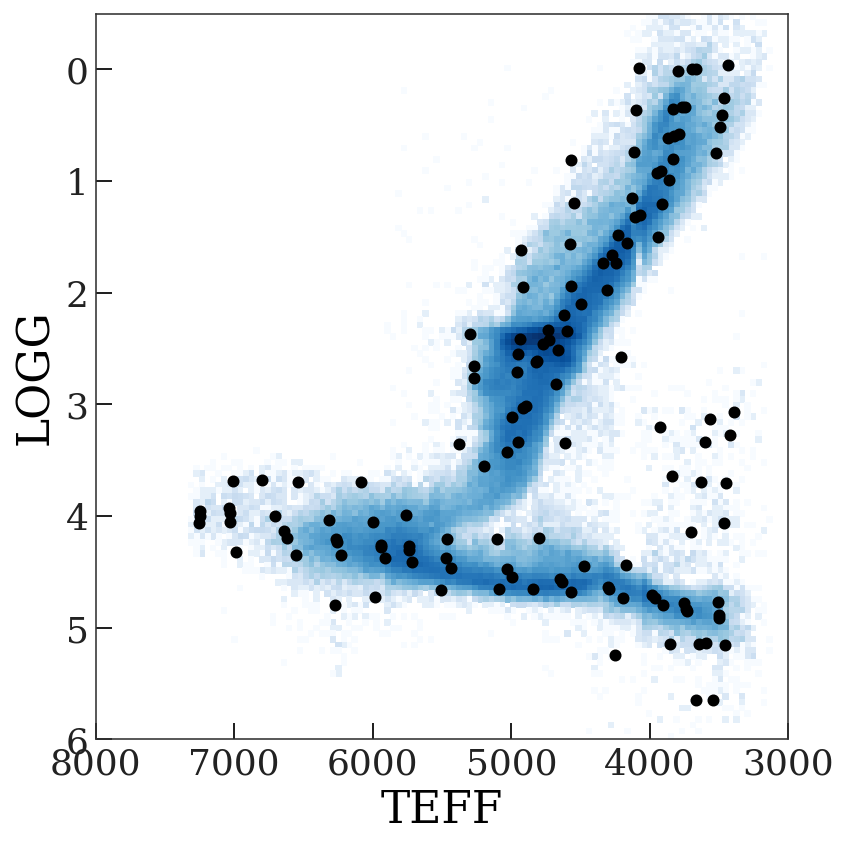

In [372]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.hist2d(allstar['TEFF'], allstar['LOGG'], 
          bins=plot_teff_logg_bins,
          norm=mpl.colors.LogNorm(),
          cmap='Blues');

ax.scatter(bin_means[:, 0],
           bin_means[:, 1],
           zorder=100)

ax.set_xlim(plot_teff_logg_bins[0].max(), plot_teff_logg_bins[0].min())
ax.set_ylim(plot_teff_logg_bins[1].max(), plot_teff_logg_bins[1].min())
ax.set_xlabel('TEFF')
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

### Find the nearest bin:

In [373]:
eval_stars, eval_visits = get_visits(
    allstar, allvisit, LOGG=(-0.5, 6), TEFF=(3000, 8000))

metric = np.array([teff_step, logg_step])
kdtree = cKDTree(bin_means / metric)

## Evaluate at a specific SNR, M/H, VSINI:

In [374]:
dense_teff_ctrs = np.linspace(teff_ctrs.min(), teff_ctrs.max(), 256)
dense_logg_ctrs = np.linspace(logg_ctrs.min(), logg_ctrs.max(), 256)
dense_teff_grid, dense_logg_grid = np.meshgrid(dense_teff_ctrs, dense_logg_ctrs)

  0%|          | 0/136 [00:00<?, ?it/s]

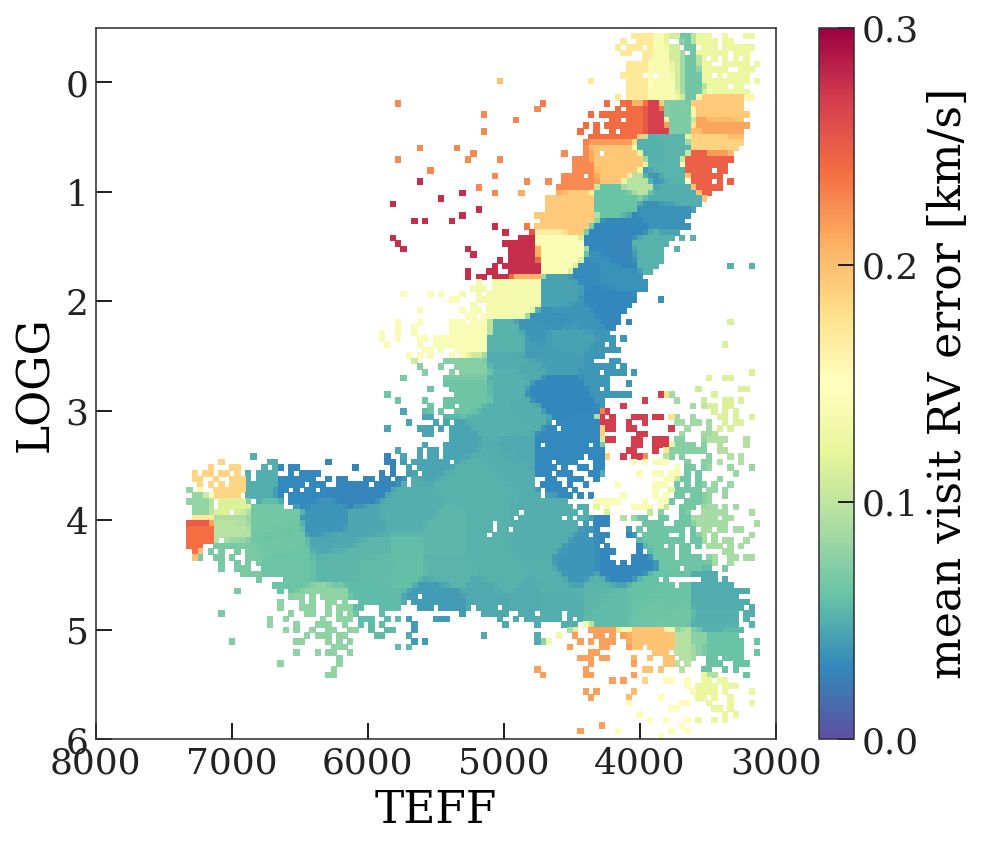

In [375]:
X = np.stack((dense_teff_grid.ravel(), dense_logg_grid.ravel())).T
dist, idx = kdtree.query(X / metric)

tmp_errs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'snrs': np.full(idx_mask.sum(), 100),
        'm_hs': np.full(idx_mask.sum(), 0),
        'vsinis': np.full(idx_mask.sum(), 1),
    }

    with model:
        pm.set_data(eval_data)
        tmp_errs[idx_mask] = xo.eval_in_model(model.named_vars['err1'], 
                                              point=map_p)

# ---

stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                           tmp_errs, 
                           bins=plot_teff_logg_bins,
                           statistic='mean')
H = stat.statistic

tmpH, *_ = np.histogram2d(
    allstar['TEFF'], 
    allstar['LOGG'], 
    bins=plot_teff_logg_bins)
H[tmpH < 1] = np.nan

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   H.T,
                   vmin=0, vmax=0.3,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('mean visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))

ax.set_xlabel('TEFF')
ax.set_xlim(plot_teff_logg_bins[0].max(), plot_teff_logg_bins[0].min())
ax.set_ylim(plot_teff_logg_bins[1].max(), plot_teff_logg_bins[1].min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

## Evaluate for the APOGEE sample:

In [376]:
X = np.stack((eval_visits['TEFF'], eval_visits['LOGG'])).T
dist, idx = kdtree.query(X / metric)

all_errs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'snrs': eval_visits['SNR'][idx_mask],
        'm_hs': eval_visits['M_H'][idx_mask],
        'vsinis': eval_visits['VSINI'][idx_mask],
    }

    with model:
        pm.set_data(eval_data)
        all_errs[idx_mask] = xo.eval_in_model(model.named_vars['err1'], 
                                              point=map_p)

  0%|          | 0/136 [00:00<?, ?it/s]

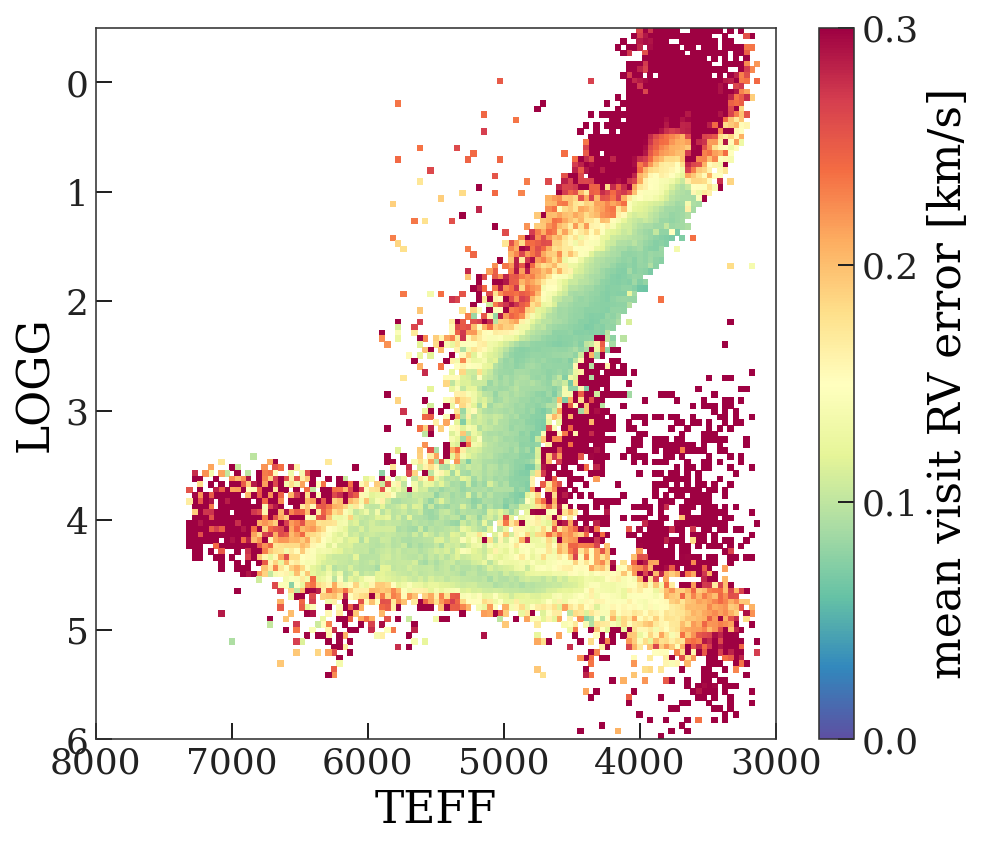

In [377]:
stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                           all_errs, 
                           bins=plot_teff_logg_bins,
                           statistic=np.nanmean)

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0, vmax=0.3,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('mean visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))

ax.set_xlabel('TEFF')
ax.set_xlim(plot_teff_logg_bins[0].max(), plot_teff_logg_bins[0].min())
ax.set_ylim(plot_teff_logg_bins[1].max(), plot_teff_logg_bins[1].min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

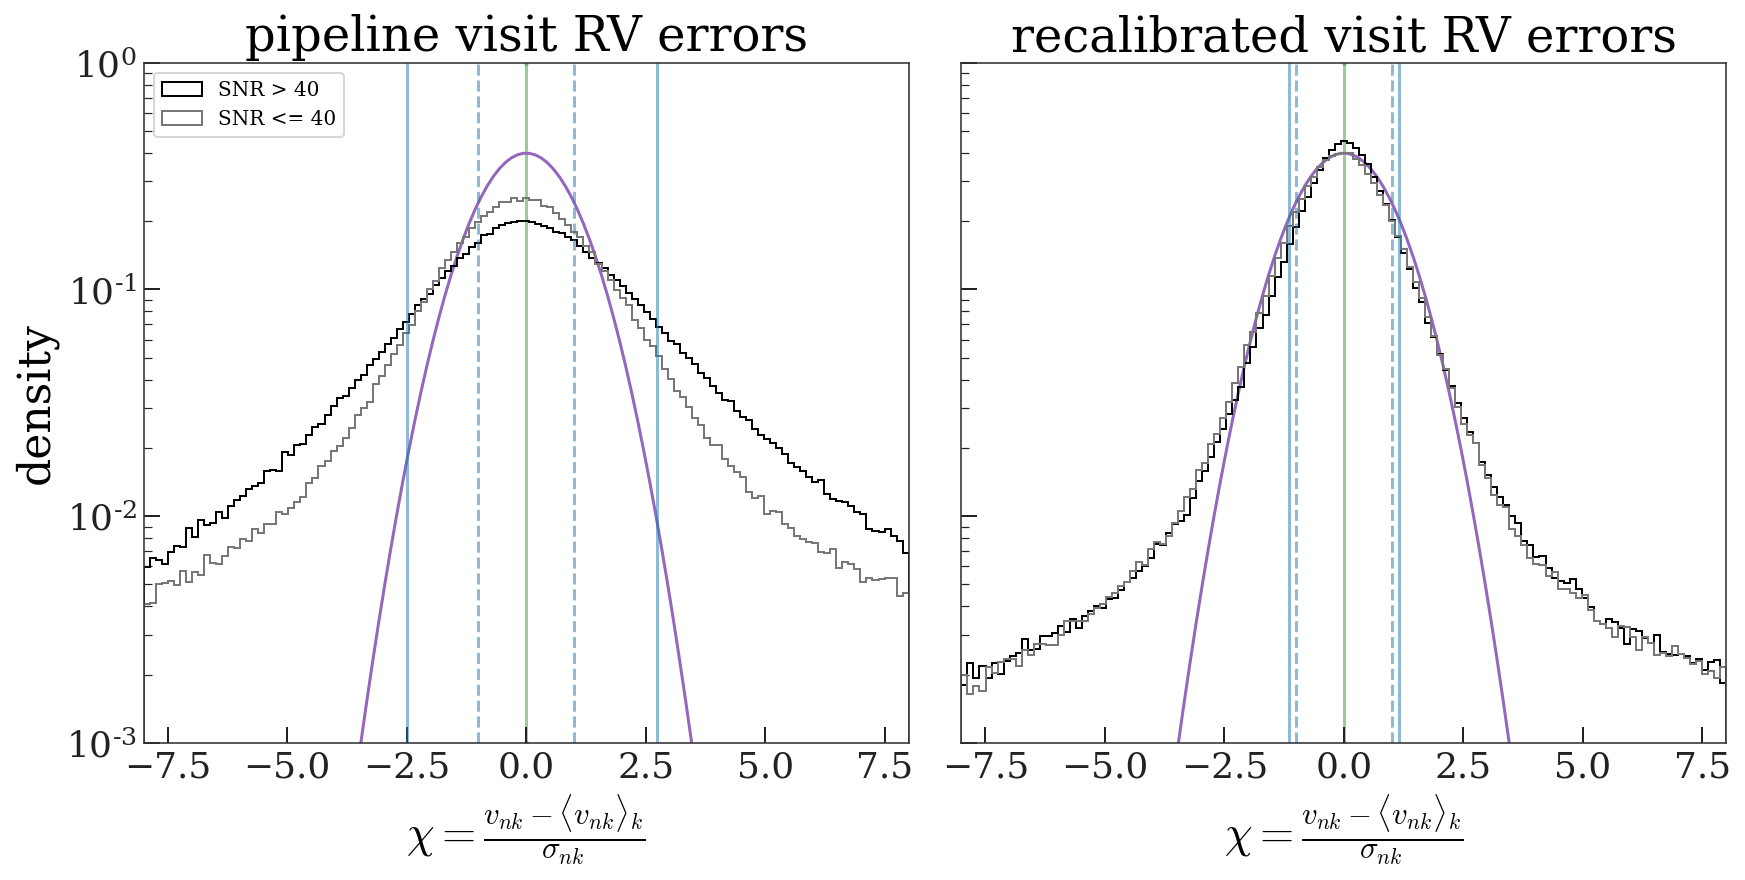

In [379]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for ax, err in zip(axes, [eval_visits['VRELERR'], all_errs]):
    chi = eval_visits['DVHELIO'] / err
    
    for line in [-1, 1]:
        ax.axvline(line, marker='', ls='--', color='tab:blue', alpha=0.5)    
    for line in np.percentile(chi, [16, 84]):
        ax.axvline(line, marker='', ls='-', color='tab:blue', alpha=0.5)

    snr_split = eval_visits['SNR'] > 40
    ax.hist(chi[snr_split], 
            histtype='step',
            bins=np.linspace(-8, 8, 128), 
            density=True,
            label='SNR > 40', color='k')
    ax.hist(chi[~snr_split], 
            histtype='step',
            bins=np.linspace(-8, 8, 128), 
            density=True, 
            label='SNR <= 40', color='#777777')

    ax.set_xlabel(r'$\chi = \frac{v_{nk}-\langle v_{nk}\rangle_k}{\sigma_{nk}}$')
    ax.axvline(0, zorder=-10, alpha=0.5, color='tab:green')
    
    _grid = np.linspace(-8, 8, 128)
    ax.plot(_grid, norm.pdf(_grid, 0, 1.), 
            zorder=-1, color='tab:purple',
            marker='')

ax.set_xlim(-8, 8)
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e0)
axes[0].legend(loc='upper left')
axes[0].set_ylabel('density')

axes[0].set_title('pipeline visit RV errors', fontsize=24)
axes[1].set_title('recalibrated visit RV errors', fontsize=24)

fig.set_facecolor('w')

### Color tesselation by other model parameters:

  0%|          | 0/136 [00:01<?, ?it/s]

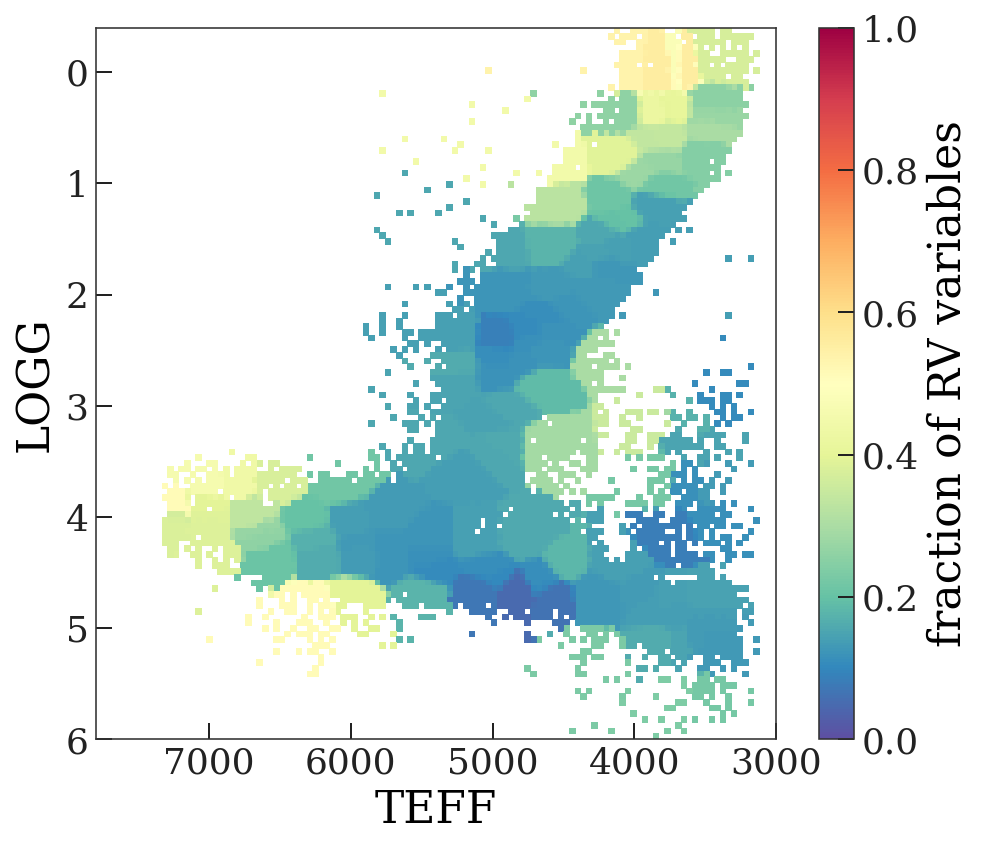

In [380]:
arr = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    arr[idx_mask] = sum(map_p['w'][1:])

stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                           arr, 
                           bins=plot_teff_logg_bins)

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0, vmax=1,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('fraction of RV variables')

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

### At fixed metallicity:

  0%|          | 0/136 [00:00<?, ?it/s]

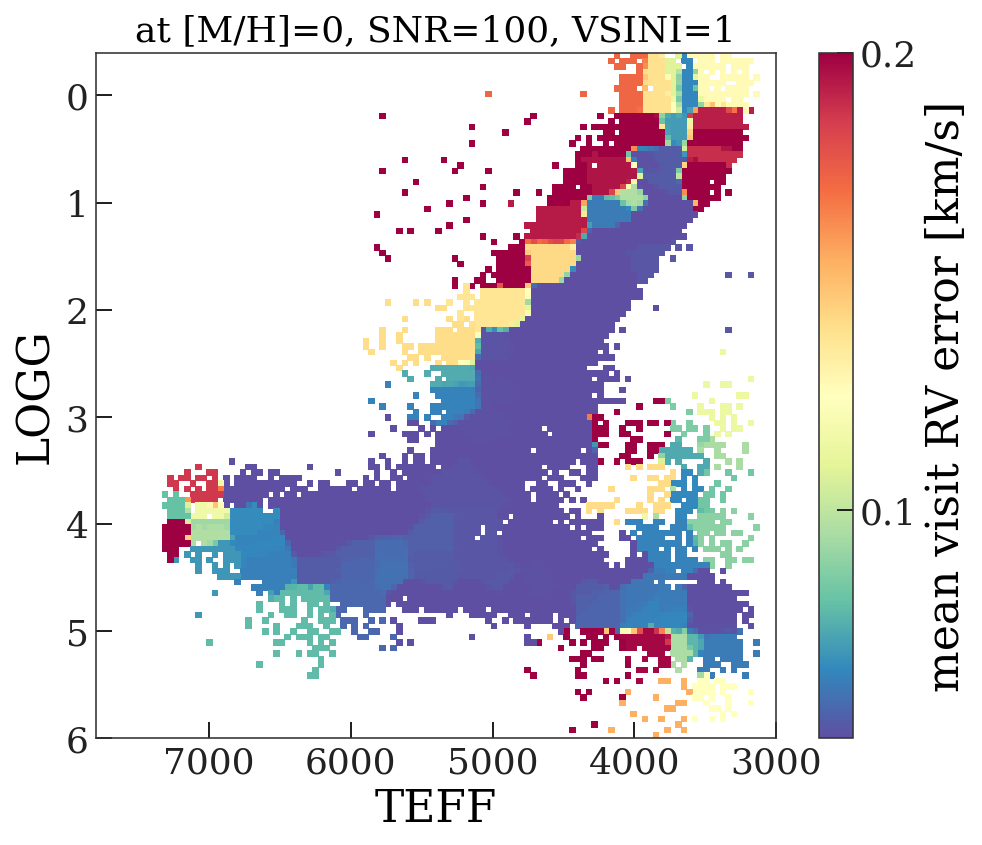

In [381]:
snr_plot = 100
vsini_plot = 1.

tmp_errs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'snrs': np.full(idx_mask.sum(), snr_plot),
        'm_hs': np.full(idx_mask.sum(), 0.),
        'vsinis': np.full(idx_mask.sum(), vsini_plot)
    }

    with model:
        pm.set_data(eval_data)
        tmp_errs[idx_mask] = xo.eval_in_model(err1, point=map_p)

stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                           tmp_errs, 
                           bins=plot_teff_logg_bins)

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0.05, vmax=0.2,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('mean visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))
ax.set_title(f'at [M/H]=0, SNR={snr_plot}, VSINI={vsini_plot:.0f}', fontsize=18)

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

### At low SNR

  0%|          | 0/136 [00:00<?, ?it/s]

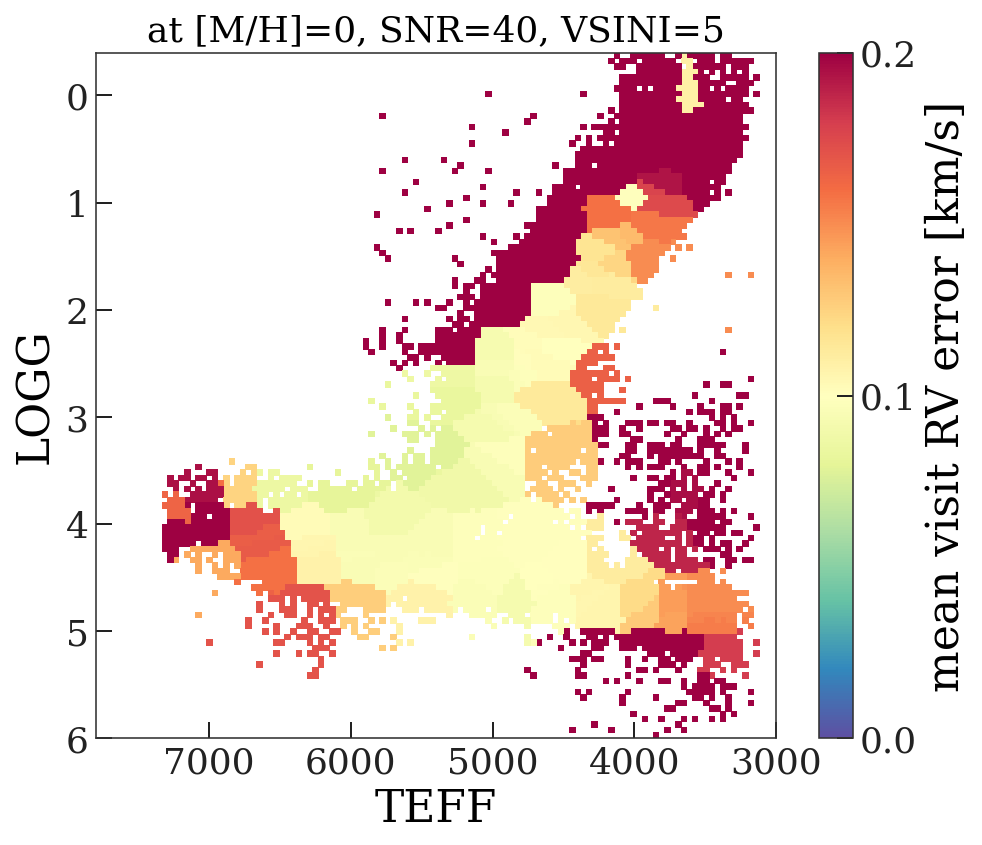

In [383]:
snr_plot = 40
vsini_plot = 5.

tmp_errs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'snrs': np.full(idx_mask.sum(), snr_plot),
        'm_hs': np.full(idx_mask.sum(), 0.),
        'vsinis': np.full(idx_mask.sum(), vsini_plot)
    }

    with model:
        pm.set_data(eval_data)
        tmp_errs[idx_mask] = xo.eval_in_model(err1, point=map_p)

stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                           tmp_errs, 
                           bins=plot_teff_logg_bins,
                           statistic='median')

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0, vmax=0.2,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('mean visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))
ax.set_title(f'at [M/H]=0, SNR={snr_plot}, VSINI={vsini_plot:.0f}', fontsize=18)

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

### Plot all parameters on grid:

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

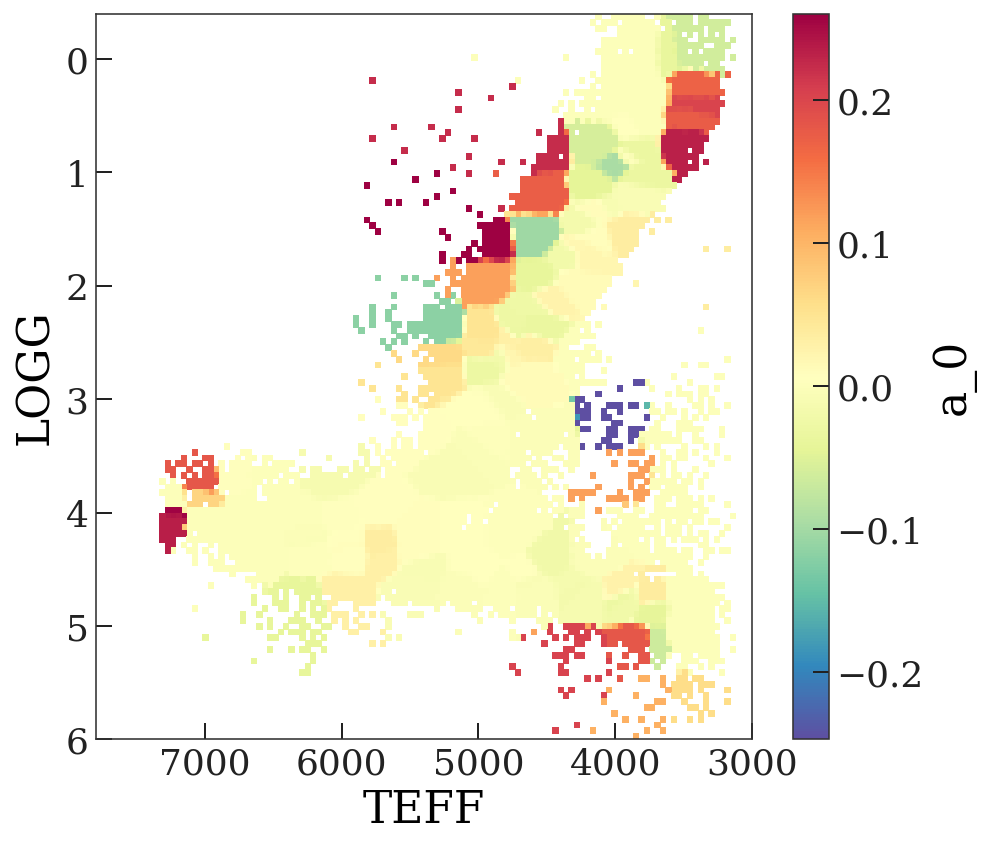

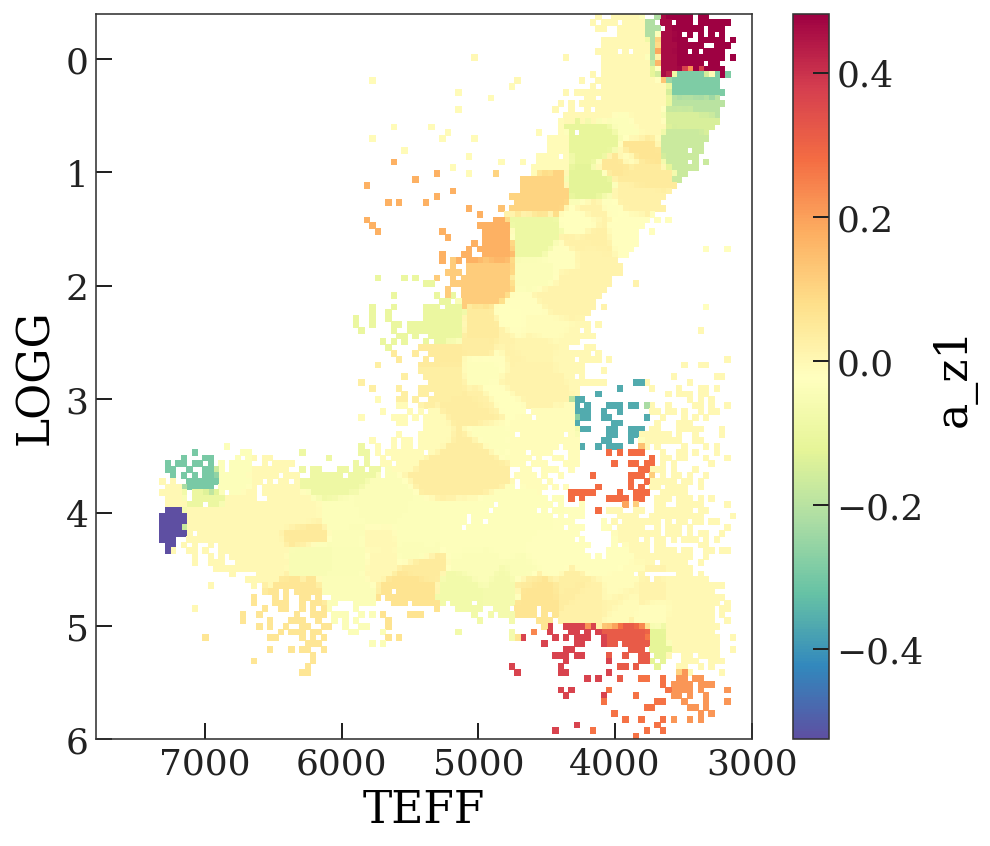

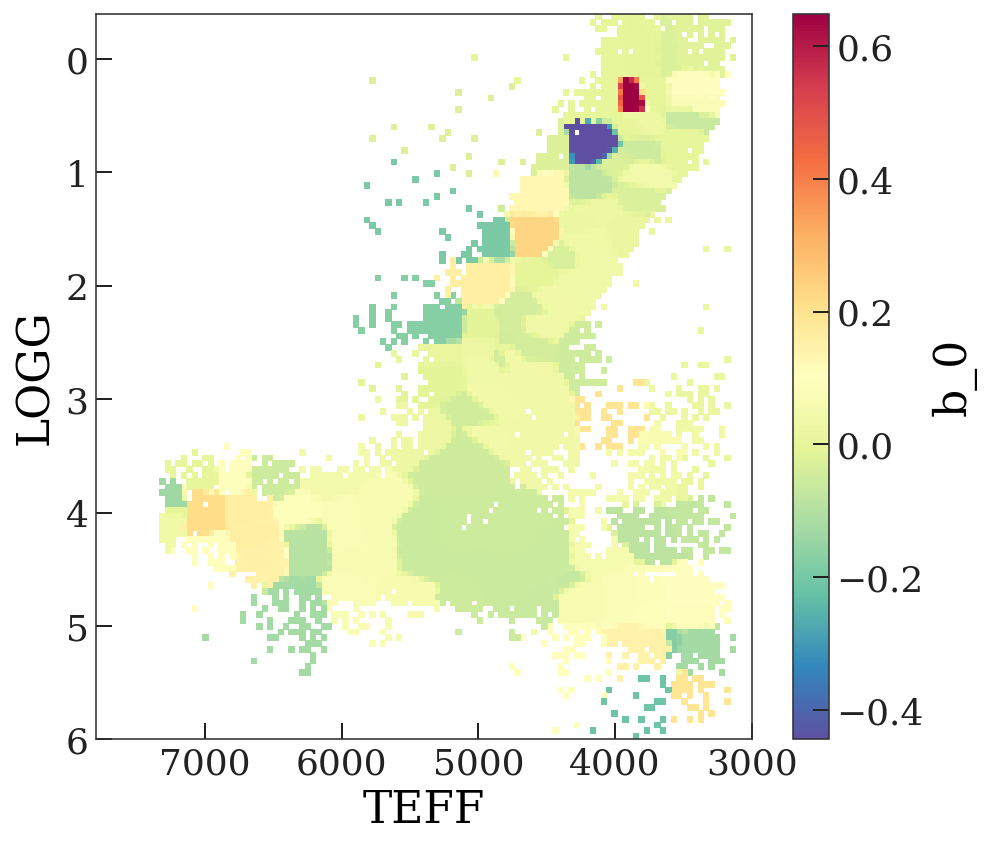

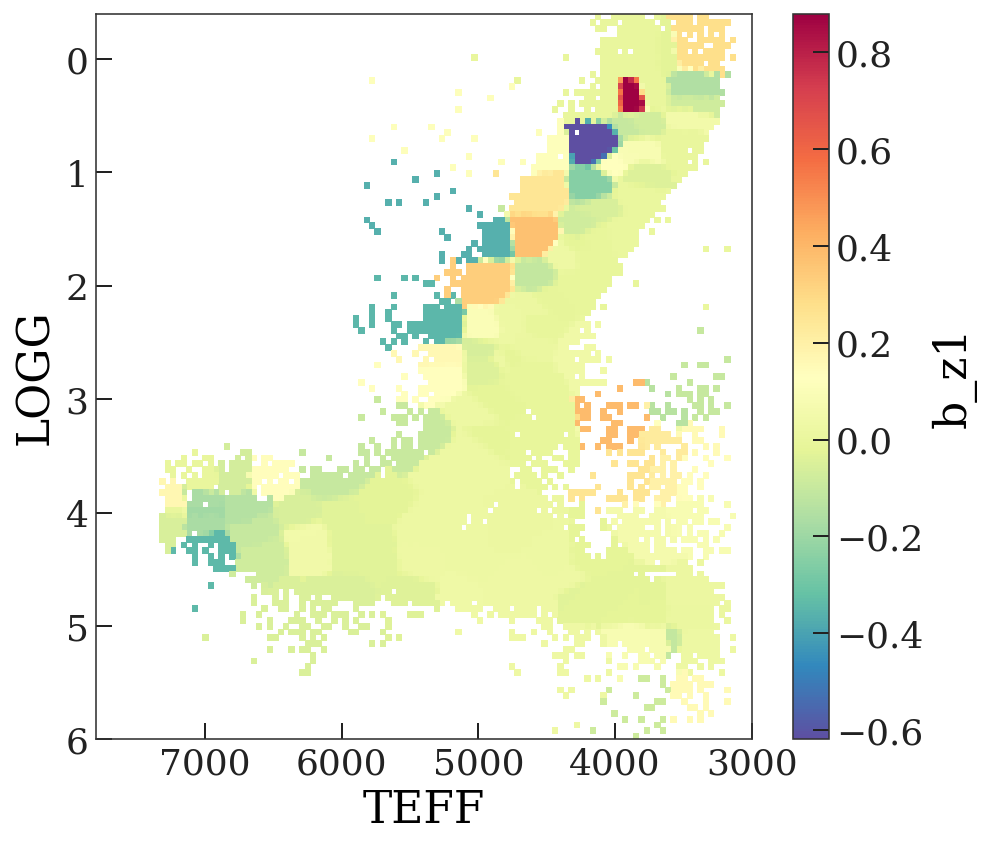

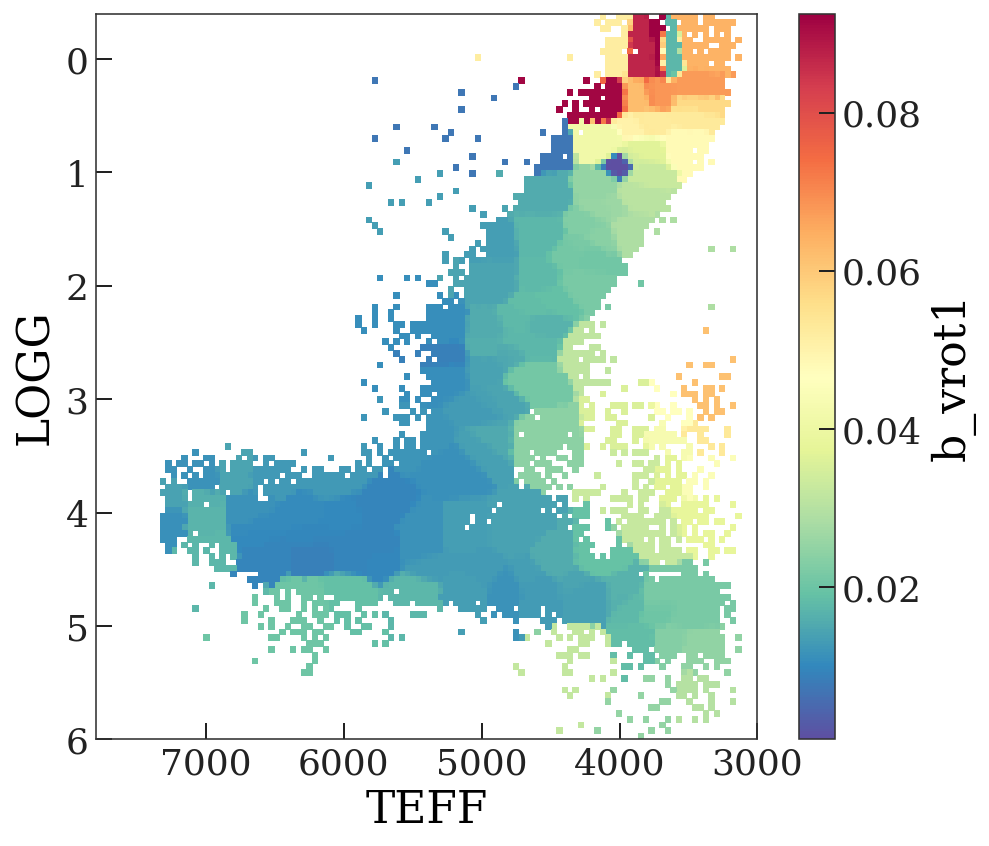

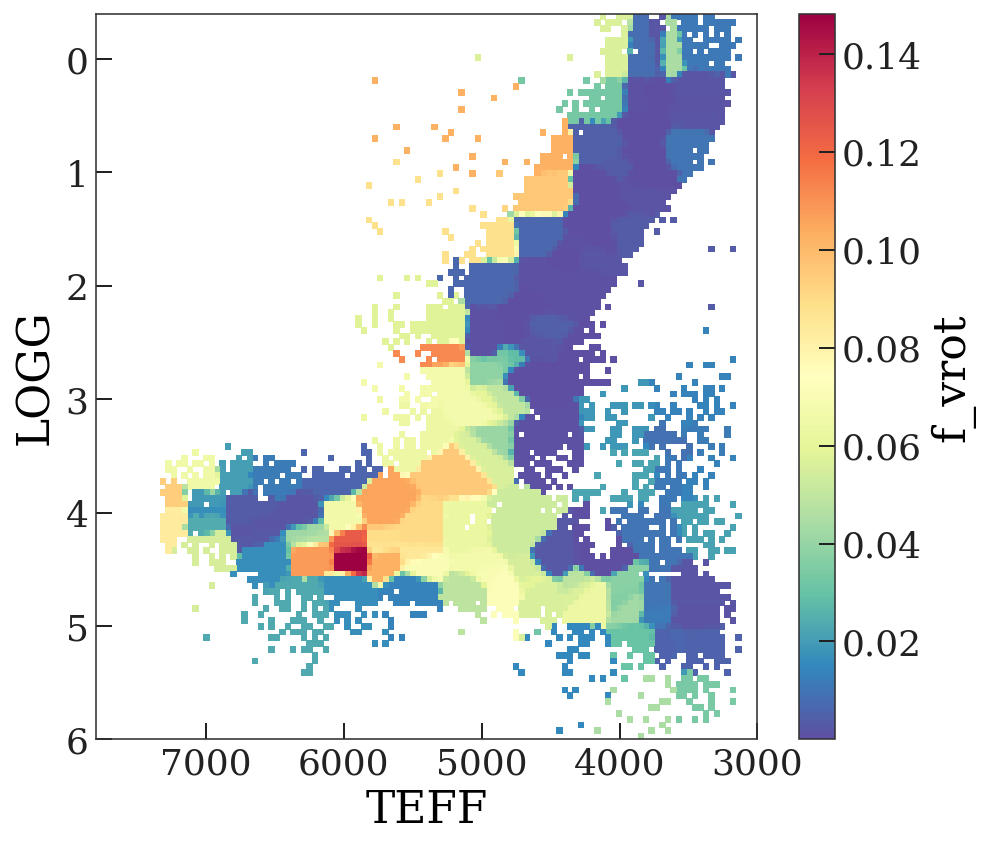

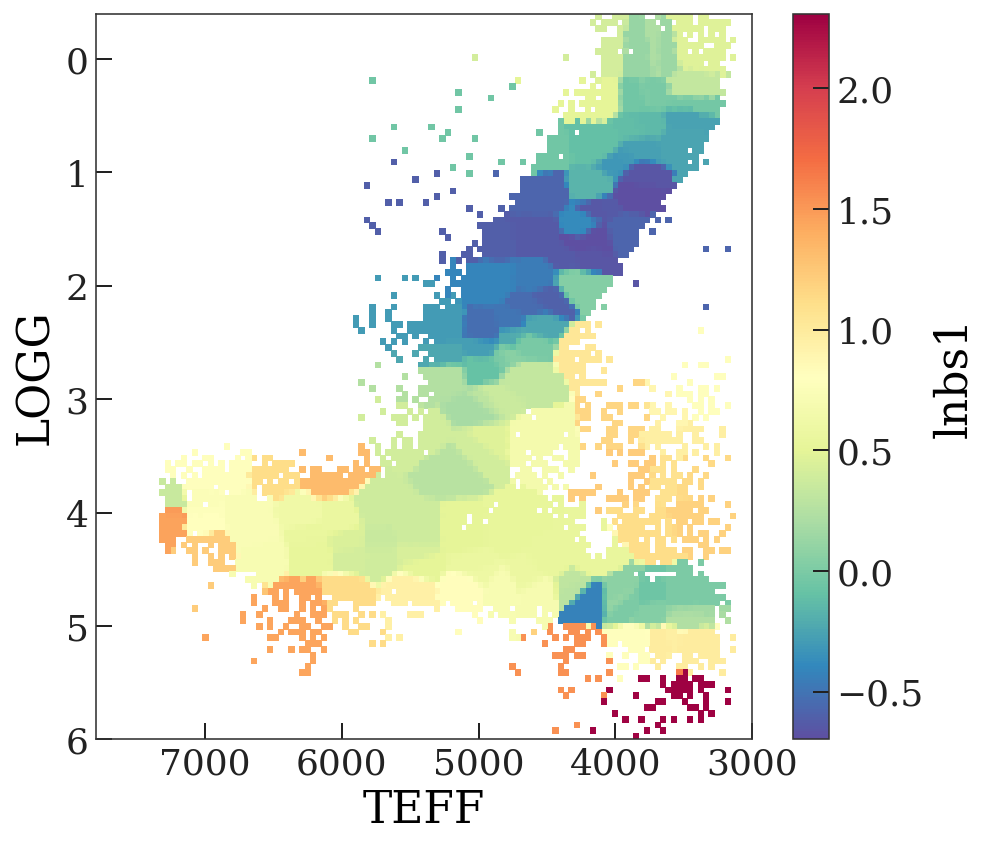

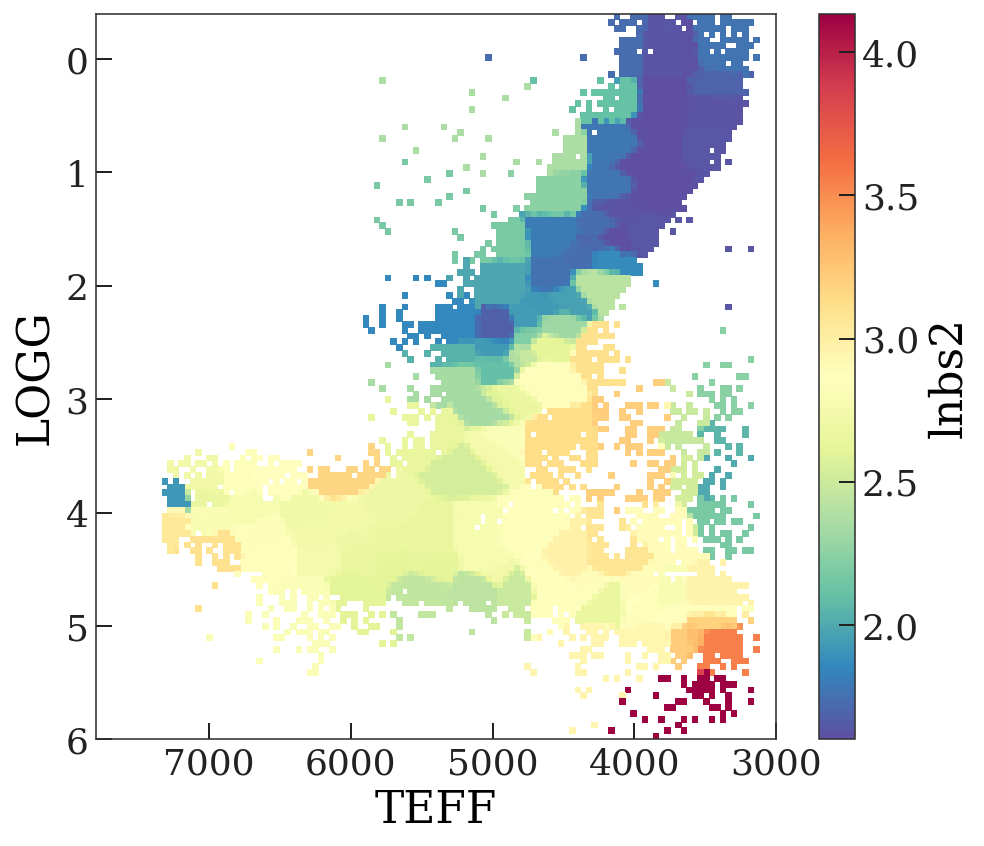

In [385]:
for param_name in ['a_0', 'a_z1',
                   'b_0', 'b_z1', 
                   'b_vrot1', 'f_vrot',
                   'lnbs1', 'lnbs2']:
    arr = np.full(len(idx), np.nan)
    for i in tqdm(np.unique(idx)):
        if i >= len(map_estimates):
            continue

        idx_mask = idx == i
        map_p = map_estimates[i]
        arr[idx_mask] = map_p[param_name]

    stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                               arr, 
                               bins=plot_teff_logg_bins)

    fig, ax = plt.subplots(figsize=(7, 6))

    cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                       stat.statistic.T,
                       # vmin=0, vmax=1,
                       cmap='Spectral_r')

    cb = fig.colorbar(cs)
    cb.set_label(param_name)

    ax.set_xlabel('TEFF')
    ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
    ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
    ax.set_ylabel('LOGG')

    fig.tight_layout()
    fig.set_facecolor('w')

---

# Apply to the full allVisit file:

In [386]:
full_allstar = at.Table.read(allstar_file, hdu=1)
full_allvisit = at.Table.read(allvisit_file, hdu=1)

eval_stars, eval_visits = get_visits(
    full_allstar, full_allvisit,
    TEFF=(2500, 8000), 
    LOGG=(-1, 6),
    M_H=(-4, 1),
    SNR=(2, 1e6),
    VSINI=(0, 100))

tmp_mask = np.all([np.isfinite(eval_visits[k]) 
                   for k in ['LOGG', 'TEFF', 'M_H', 'SNR']], 
                  axis=0)
eval_visits = eval_visits[tmp_mask]

print(len(full_allstar), len(full_allvisit))
print(len(eval_stars), len(eval_visits))

723825 2601121
660467 2354022


In [388]:
X = np.stack((eval_visits['TEFF'], eval_visits['LOGG'])).T
metric = np.array([teff_step, logg_step])

kdtree = cKDTree(bin_means / metric)
dist, idx = kdtree.query(X / metric)

In [389]:
all_errs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'snrs': eval_visits['SNR'][idx_mask],
        'vsinis': eval_visits['VSINI'][idx_mask],
        'm_hs': eval_visits['M_H'][idx_mask],
    }

    with model:
        pm.set_data(eval_data)
        all_errs[idx_mask] = xo.eval_in_model(err1, point=map_p)

  0%|          | 0/136 [00:00<?, ?it/s]

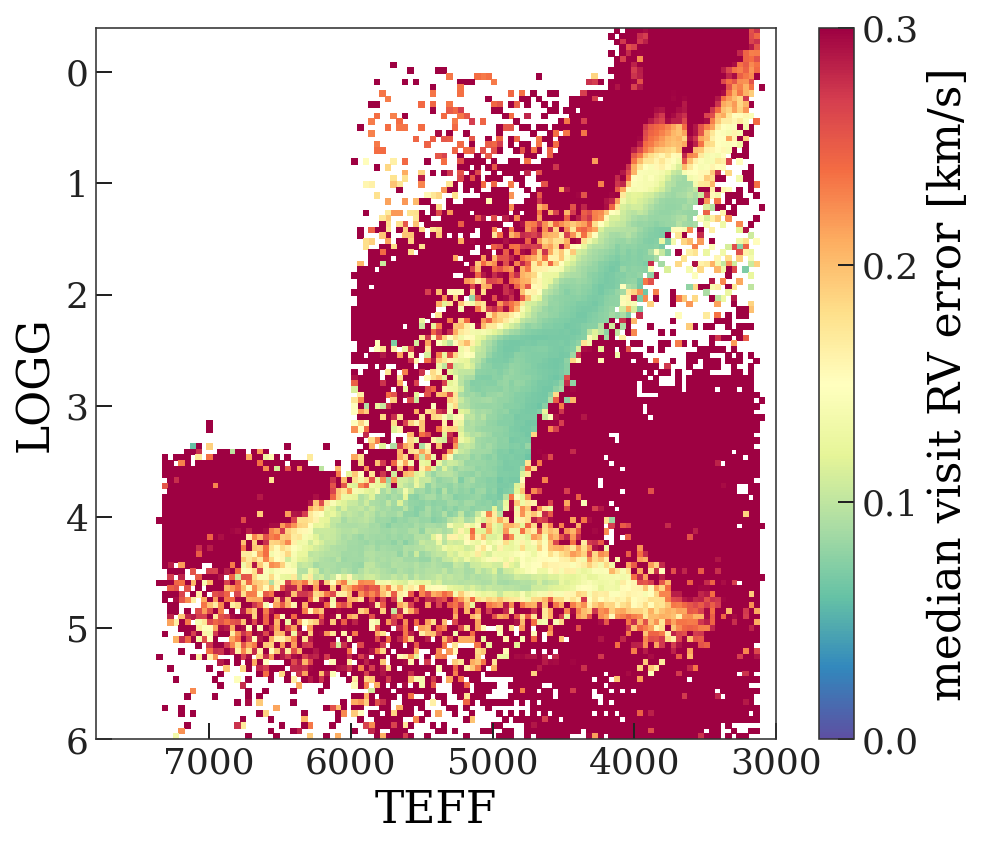

In [390]:
stat = binned_statistic_2d(
    X[:, 0], X[:, 1], 
    all_errs, 
    bins=plot_teff_logg_bins,
    statistic='median')

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0, vmax=0.3,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('median visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

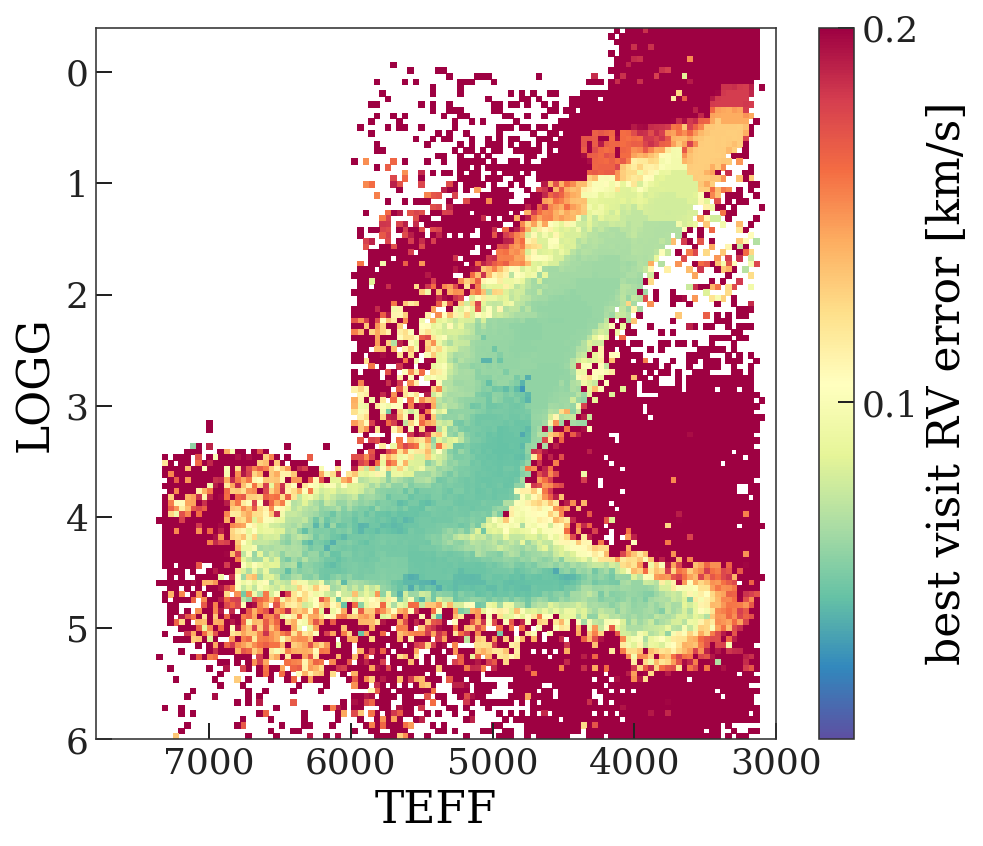

In [391]:
stat = binned_statistic_2d(
    X[:, 0], X[:, 1], 
    all_errs, 
    bins=plot_teff_logg_bins,
    statistic='min')

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0.01, vmax=0.2,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('best visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

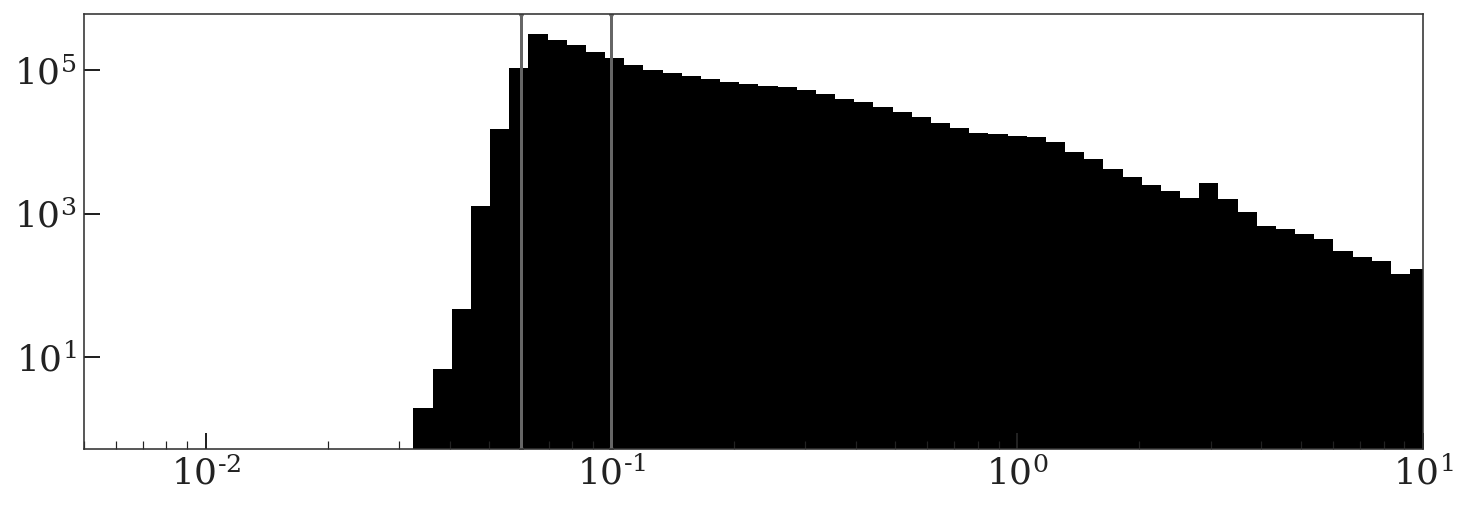

In [392]:
plt.figure(figsize=(12, 4))
plt.hist(all_errs, bins=np.geomspace(1e-3, 1e3, 128)); #.min()
plt.xticks(10. ** np.arange(-3, 2+1))
plt.xlim(5e-3, 1e1)
plt.axvline(0.1)
plt.axvline(0.06)
plt.xscale('log')
plt.yscale('log')

In [394]:
for q in [5, 25, 50, 75, 95]:
    xxx = np.percentile(all_errs, q) * 1e3
    print(f'{str(q).rjust(2)}% of visits have err < {xxx:.0f} m/s')

 5% of visits have err < 62 m/s
25% of visits have err < 74 m/s
50% of visits have err < 101 m/s
75% of visits have err < 199 m/s
95% of visits have err < 658 m/s


In [395]:
tbl = at.Table()
for key in ['APOGEE_ID', 'PLATE', 'MJD', 'FIBERID']:
    tbl[key] = eval_visits[key]
    
tbl['CALIB_VERR'] = np.clip(all_errs, None, 1e2)

basename = os.path.splitext(allvisit_file.parts[-1])[0]
tbl.write(f'../cache/{basename}-calib-verr.fits', overwrite=True)

In [396]:
print(f'../cache/{basename}-calib-verr.fits')

../cache/allVisit-dr17-l33alpha-calib-verr.fits


---

# How many binaries?

Note: this has to be run after running Make-parent-sample.ipynb:

In [456]:
parent_visits = at.Table.read('../cache/visits-dr17alpha-min3-calibverr.fits', 
                              hdu=1)

_, parent_visits = get_visits(
    full_allstar, parent_visits,
    TEFF=(2500, 8000), 
    LOGG=(-1, 6),
    M_H=(-4, 1),
    SNR=(2, 1e6),
    VSINI=(0, 50))

len(parent_visits)

1628155

In [458]:
X = np.stack((parent_visits['TEFF'], parent_visits['LOGG'])).T
dist, idx = kdtree.query(X / metric)

all_single_probs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'vs': np.array(parent_visits['DVHELIO'][idx_mask]),
        'snrs': np.array(parent_visits['SNR'][idx_mask]),
        'm_hs': np.array(parent_visits['M_H'][idx_mask]),
        'vsinis': np.array(parent_visits['VSINI'][idx_mask]),
    }

    with model:
        pm.set_data(eval_data)
        logps = [xo.eval_in_model(model.named_vars[f'logp{i+1}'], 
                                  point=map_p) + map_p['w'][i]
                 for i in range(3)]
    
    all_single_probs[idx_mask] = np.exp(logps[0] - logsumexp(logps, axis=0))

  0%|          | 0/136 [00:00<?, ?it/s]

In [460]:
tmp = at.Table()
tmp['apogee_id'] = parent_visits['APOGEE_ID']
tmp['prob'] = 1 - all_single_probs
tmp = tmp[np.isfinite(parent_visits['DVHELIO']) & (parent_visits['DVHELIO'] != 0)]
tmpdf = tmp.to_pandas()
len(tmpdf)

1628155

In [461]:
gdf = tmpdf.groupby('apogee_id').mean()
(gdf['prob'] > 0.25).sum(), (gdf['prob'] > 0.5).sum(), (gdf['prob'] > 0.8).sum()

(67358, 42790, 28822)